In [2]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
import numpy as np
import torch
import sys
import torch.nn.functional as F
sys.path.append("CLIP")

import clip
from simple_tokenizer import SimpleTokenizer
print("Torch version:", torch.__version__)

MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}
#! wget {MODELS["ViT-B/32"]} -O model.pt

model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Torch version: 1.7.1+cu110
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [37]:
import numpy as np
male=["man","male","masculine","men","transman"]
female=["woman","women","feminine","female","transwoman"]
other=["non-gendered","asexual","non-binary","transgender"]
random=["Test","watermelon","disconnected","text","random","words"]
tokenizer = SimpleTokenizer()
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']
outputs=torch.zeros(3,  512, dtype=torch.float)
with torch.no_grad():
    for j,texts in enumerate(list([male,female,random])):
        e=torch.nn.EmbeddingBag(len(texts), 512,mode='mean').to('cuda',non_blocking=True)

        text_tokens = [tokenizer.encode("This is a " + desc) for desc in texts]
        text_input = torch.zeros(len(texts),  77, dtype=torch.long)

        for i, tokens in enumerate(text_tokens):
            tokens = [sot_token] + tokens + [eot_token]
            text_input[i, :len(tokens)] = torch.tensor(tokens)
        text_input = text_input.long().cuda()
        text_features= model.encode_text(text_input).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        print(text_features.shape)
        embeddingmean=e(text_features.long()).cpu()[-1]
        print(embeddingmean.shape)
        outputs[j,:]=embeddingmean.float()
    #outputs=torch.stack(outputs,dim=-1).numpy()
    #outputs=np.linalg.norm(outputs, axis=-1)
    #outputs /= outputs.norm(dim=-1, keepdim=True)
    #print(outputs)
    grads=torch.zeros(outputs.shape)
    for i in range(outputs.shape[0]):
        grads[i]=outputs[i]-outputs[i-1]
    grads /=grads.norm(dim=-1,keepdim=True)
                       #p=2)
    similarity=(grads.cpu().numpy() @ grads.cpu().numpy().T)
#     print(value)
#     value2=grad1.cpu().numpy() @ grad2.cpu().numpy().T
#     print(value2)
#     value1=grad2.cpu().numpy() @ grad0.cpu().numpy().T
#     print(value1)
    #print("deviance of genders from linear space:{} {} {} {} {}".format(sum(value1),sum(value),sum(value2),min(value), max(value)))
    #print(value)

torch.Size([5, 512])
torch.Size([512])
torch.Size([5, 512])
torch.Size([512])
torch.Size([6, 512])
torch.Size([512])


Text(0.5, 1.0, 'Cosine similarity between text and image features')

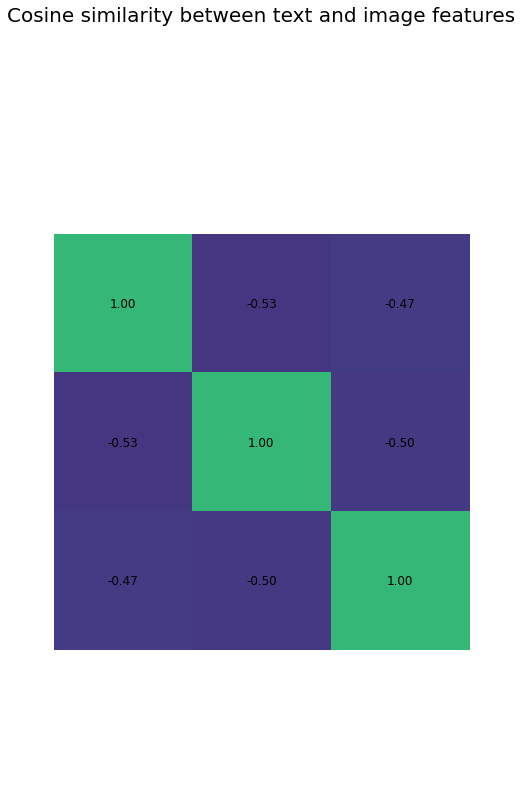

In [38]:
import matplotlib.pyplot as plt

count =3

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=-1, vmax=2)
# plt.colorbar()
plt.yticks([])
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)